# Data Science Final Project
by: Christopher Yarbro and Lakeland Galinson
[link to website](yarbschris.github.io/ds-final)

## Intro
Our names are Christopher Yarbro and Lakeland Galinson. We are seniors at Tulane University studying Computer Science. This website will host the code, figures, and anything else necessary for our Final Project in Data Science.

**The goal for this project** is to explore geographic crime data in the city of New Orleans. We will aim examine the relationship between crime frequency and type to location and create an interactive visualization showing crime/police reports on a map.

## Research Questions
1. How do reported crimes and 911 calls vary by zoning type across New Orleans?

2. Are commercial or mixed-use zones associated with greater crime density than residential zones?/n

3. Do certain categories of crime (e.g., property, violent, nuisance) appear disproportionately in specific zoning areas?

These questions will guide both exploratory visualizations and later statistical testing in our final tutorial.

## Organization
Our first step was to create a git repository hosted on github that we can both access and edit. We are roommates, so we have been able to meet regularly to discuss our plans for the project.



## Data Sets

### New Orleans Police Department Calls for Service 2025
This dataset, provided by the Orleans Parish Communication District, shows instances of reports filed by phone to NOPD. It contains information about the type of report, the time it occured, and the location of the report. 

The dataset can be found [here](https://catalog.data.gov/dataset/calls-for-service-2025).



### New Orleans Electronic Police Reports 2025
This dataset is a collection of all police reports in 2025. It contains information about the location, type of report, date, and demographic information about the victim and offender.

The dataset can be found [here](https://data.nola.gov/Public-Safety-and-Preparedness/Electronic-Police-Report-2025/agqi-9adb/about_data).

With this dataset, we hope to answer questions regarding the **frequency of crime reports by geographic location**. In our final interactive visualization, data regarding crime type, demographics, etc will be available via tooltip. 

We will load, clean, and explore this dataset below.




In [ ]:
import pandas as pd
import seaborn as sns
import os
import math
import re

PARENT_DIR = os.getcwd()
DATA_DIR = os.path.join(PARENT_DIR, "data")

PATH_TO_POLICE_REPORTS = os.path.join(DATA_DIR, "Electronic_Police_Report_2025_20251013.csv")
police_reports = pd.read_csv(PATH_TO_POLICE_REPORTS)
police_reports.head()

,Item_Number,District,Location,Disposition,Signal_Type,Signal_Description,Occurred_Date_Time,Charge_Code,Charge_Description,Offender_Number,...,Offender_Gender,Offender_Age,Victim_Number,PersonType,Victim_Race,Victim_Gender,Victim_Age,Victim_Fatal_Status,Hate Crime,Report Type
0,H-11186-25,5,014XX Montegut St,OPEN,62C,SIMPLE BURGLARY (VEHICLE),2025-08-10 10:30:00,14 62,SIMPLE BURGLARY,1.0,...,MALE,NaN,2.0,VICTIM,BLACK,MALE,46.0,Non-fatal,NaN,Incident Report
1,H-11186-25,5,014XX Montegut St,OPEN,62C,SIMPLE BURGLARY (VEHICLE),2025-08-10 10:30:00,14 56,SIMPLE CRIMINAL DAMAGE TO PROPERTY,1.0,...,MALE,NaN,2.0,VICTIM,BLACK,MALE,46.0,Non-fatal,NaN,Incident Report
2,H-00477-25,1,017XX Tulane Av,CLOSED,67A,AUTO THEFT,2025-08-01 08:43:00,14 67.26,THEFT OF A MOTOR VEHICLE,1.0,...,MALE,43.0,1.0,VICTIM,BLACK,FEMALE,33.0,Non-fatal,NaN,Supplemental Report
3,H-00477-25,1,017XX Tulane Av,CLOSED,67A,AUTO THEFT,2025-08-01 08:43:00,14 69,ILLEGAL POSSESSION OF STOLEN THINGS,1.0,...,MALE,43.0,1.0,VICTIM,BLACK,FEMALE,33.0,Non-fatal,NaN,Supplemental Report
4,H-00477-25,1,017XX Tulane Av,CLOSED,67A,AUTO THEFT,2025-08-01 08:43:00,NaN,NaN,1.0,...,MALE,43.0,2.0,VICTIM,NaN,NaN,NaN,Non-fatal,NaN,Supplemental Report


Some quick descriptive statistics:

In [85]:
police_reports.describe()

,District,Offender_Number,OffenderID,Offender_Age,Victim_Number,Victim_Age
count,64500.000000,35434.000000,35434.000000,17155.000000,63088.000000,47467.000000
mean,4.930341,1.194446,950833.847745,35.176683,1.455919,40.605494
std,2.306907,0.998804,11692.490196,12.668838,0.994950,16.198582
min,1.000000,-1.000000,929934.000000,0.000000,1.000000,0.000000
25%,3.000000,1.000000,941522.250000,25.000000,1.000000,29.000000
50%,5.000000,1.000000,951099.500000,34.000000,1.000000,38.000000
75%,7.000000,1.000000,961187.000000,43.000000,2.000000,51.000000
max,8.000000,79.000000,970738.000000,94.000000,67.000000,125.000000


We have some cleaning up to do, let's start by removing supplemental reports:

In [86]:
police_reports.drop(police_reports[police_reports["Report Type"].str.contains("Supplemental Report")].index, inplace=True)


We can also drop some columns that are not of much value for our specific goals. We will keep a few temporarily for exploratory purposes.

In [87]:
colsToDrop = ["Item_Number", "Disposition", "Signal_Type", "Charge_Code", "Offender_Number", "Victim_Number", "PersonType", "Victim_Fatal_Status", "Hate Crime", "Report Type", "OffenderStatus", "OffenderID", "Offender_Race", "Offender_Gender", "Offender_Age", "Charge_Description"]

for col in colsToDrop:
    police_reports.drop(col, axis=1, inplace=True)

Let's make sure our df doesn't contain any null values.

In [88]:
police_reports.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53516 entries, 0 to 64499
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   District            53516 non-null  int64  
 1   Location            53516 non-null  object 
 2   Signal_Description  53516 non-null  object 
 3   Occurred_Date_Time  53516 non-null  object 
 4   Victim_Race         45532 non-null  object 
 5   Victim_Gender       45562 non-null  object 
 6   Victim_Age          40033 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 3.3+ MB


It looks like Victim Race, Victim Gender, and Victim Age all contain null values. In the case of race and gender, we may just have to drop these rows. For victim age, we can fill null values with the mean. Since these columns are not necessarily related to our first three main objectives, we will create a new dataframe.

In [89]:
# Copy df
reports_with_victim_info = police_reports.copy()

# Handle NaNs
for col in ["Victim_Race", "Victim_Gender"]:
    reports_with_victim_info[col].replace("UNKNOWN", None, inplace=True)
    
reports_with_victim_info["Victim_Age"].fillna(police_reports["Victim_Age"].mean(), inplace=True)
reports_with_victim_info.dropna(inplace=True)

# Remove columns from main df
victimCols = ["Victim_Race", "Victim_Gender", "Victim_Age"]
for col in victimCols:
    police_reports.drop(col, axis=1, inplace=True)

/var/folders/hf/dsd5htdx22gcfwn6rb4v_33m0000gn/T/ipykernel_33940/1879124270.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reports_with_victim_info[col].replace("UNKNOWN", None, inplace=True)
/var/folders/hf/dsd5htdx22gcfwn6rb4v_33m0000gn/T/ipykernel_33940/1879124270.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

In [90]:
reports_with_victim_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42043 entries, 0 to 64495
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   District            42043 non-null  int64  
 1   Location            42043 non-null  object 
 2   Signal_Description  42043 non-null  object 
 3   Occurred_Date_Time  42043 non-null  object 
 4   Victim_Race         42043 non-null  object 
 5   Victim_Gender       42043 non-null  object 
 6   Victim_Age          42043 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.6+ MB


Let's find the Average Age of the victims:

In [91]:
print(f"Mean Average Age: {reports_with_victim_info["Victim_Age"].mean()}")

Mean Average Age: 40.80053005161164


We can also find the standard deviation:

In [92]:
print(f"Standard Deviation of Age: {reports_with_victim_info["Victim_Age"].std()}")

Standard Deviation of Age: 15.54082557220289


[Text(0, 0.5, 'Race of Victim')]

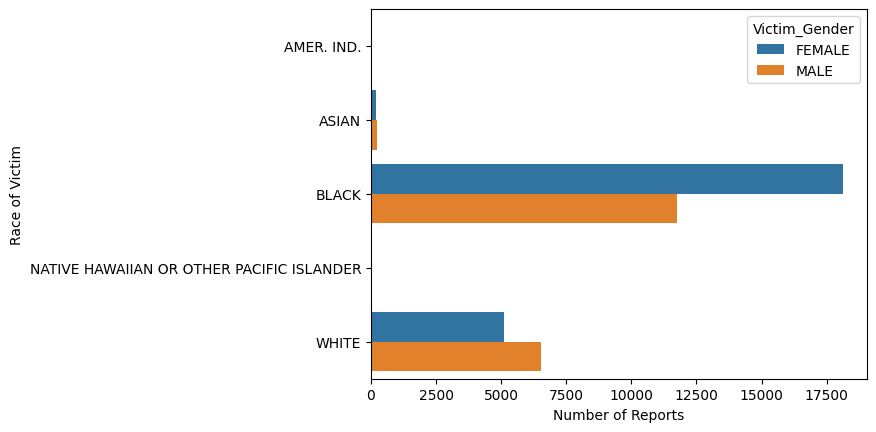

In [93]:
reports_by_race_gender = reports_with_victim_info.groupby(["Victim_Race", "Victim_Gender"]).size().reset_index(name="Number of Reports")
ax = sns.barplot(reports_by_race_gender, y="Victim_Race", x="Number of Reports", hue="Victim_Gender")
ax.set(ylabel = "Race of Victim")

We can see that black women make up an extremely high proportion of victims. However, we cannot see any data for American Indian or Naitive Hawaiian victims, so lets take the log and see if we can get a better look:

[Text(0, 0.5, 'Race of Victim'), Text(0.5, 0, 'Number of Reports (log)')]

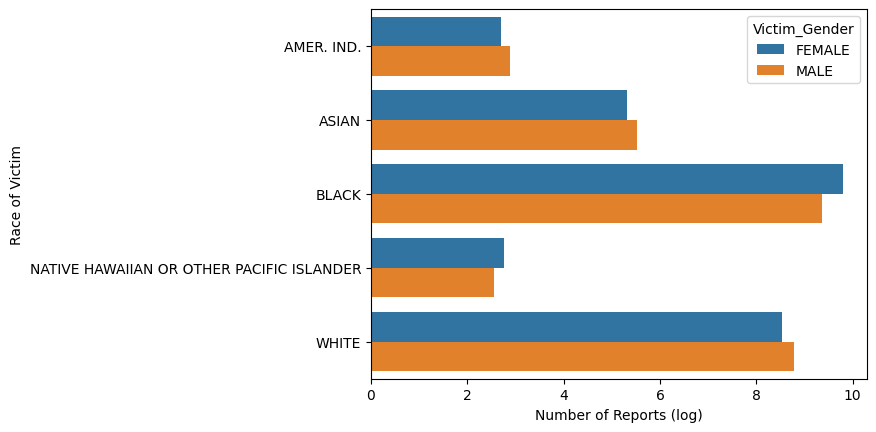

In [94]:
reports_by_race_gender["Number of Reports"] = reports_by_race_gender["Number of Reports"].apply(math.log)
ax = sns.barplot(reports_by_race_gender, y="Victim_Race", x="Number of Reports", hue="Victim_Gender")
ax.set(ylabel = "Race of Victim", xlabel= "Number of Reports (log)")

 Much better

Next we will group the data by month.

In [95]:
def isolate_year_month(entry):
    date_time_pattern = r"^\d{4}-(\d{2})-\d{2}\s\d{2}:\d{2}:\d{2}$" # Parentheses around the part of the pattern that will match the month
    return re.sub(date_time_pattern, r"\1", entry) # We use the first match to replace the entire string.

In [96]:
police_reports["Occurred_Date_Time"] = police_reports["Occurred_Date_Time"].apply(isolate_year_month)

**Note: Data is incomplete because it is from this year, but by the time project is turned in we should have almost a full year of data available**

[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Number of Reports')]

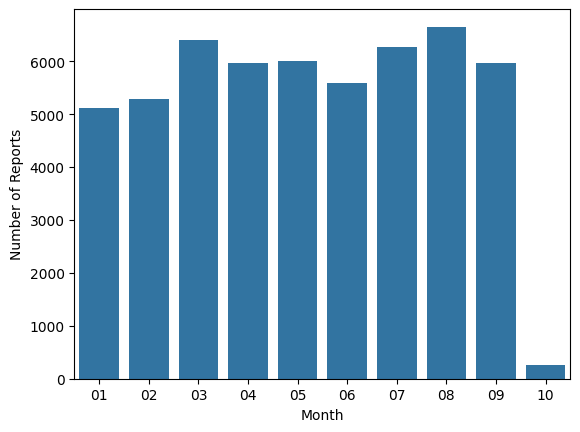

In [97]:
reports_by_month = police_reports.groupby("Occurred_Date_Time")
ax = sns.barplot(reports_by_month.size())
ax.set(xlabel="Month", ylabel="Number of Reports")

We can see two peaks, one in March and one in August. The full month that has the lowest number of reports is January.

Let's explore the data a bit more. We'll start by seeing how many reports were filed in each district.

In [98]:
reports_by_district = police_reports.groupby("District")
reports_by_district.size()

District
1     5748
2     5073
3     5992
4     4818
5     6922
6     6761
7    10357
8     7845
dtype: int64

We can make this into a bar chart to vizualize it better.

[Text(0, 0.5, 'Number of Reports')]

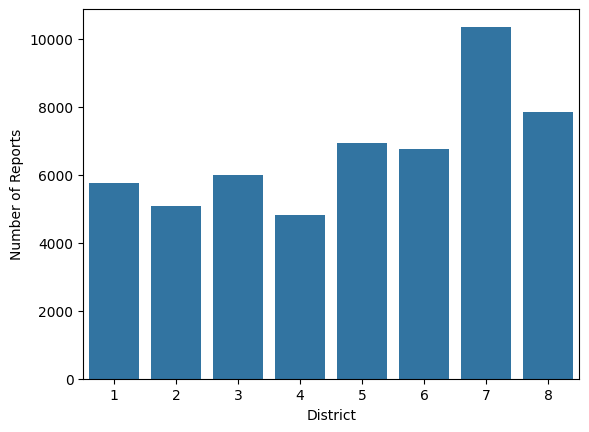

In [99]:
ax = sns.barplot(reports_by_district.size())
ax.set(ylabel="Number of Reports")

As we can see, the highest frequency of crime reports occurs in District 7. In future milestones we will explore why this might be and include an interactive map to display these statistics.